In [49]:
%matplotlib inline
import matplotlib.pyplot as plt
import gwpy
from gwpy.timeseries import TimeSeries
from numpy import *
import numpy as np
from scipy import signal
import numpy as np
from sklearn.decomposition import PCA
import yaml
import pickle


In [36]:
params=open("parameters.txt","r")

y = yaml.load(params)
cha=y['channels'].split(',')
print cha

['ASC-INP2_P_IN1_DQ', 'ASC-PRC1_P_IN1_DQ', 'ASC-PRC2_P_IN1_DQ', 'ASC-MICH_P_IN1_DQ', 'ASC-SRC1_P_IN1_DQ', 'ASC-SRC2_P_IN1_DQ', 'ASC-DHARD_P_IN1_DQ', 'ASC-DSOFT_P_IN1_DQ', 'ASC-CSOFT_P_IN1_DQ', 'ASC-DC1_P_IN1_DQ', 'ASC-DC2_P_IN1_DQ', 'ASC-DC3_P_IN1_DQ', 'ASC-DC4_P_IN1_DQ', 'ASC-DC5_P_IN1_DQ', 'SUS-OM1_M1_DAMP_P_IN1_DQ', 'SUS-OM2_M1_DAMP_P_IN1_DQ', 'SUS-OM3_M1_DAMP_P_IN1_DQ', 'SUS-OMC_M1_DAMP_P_IN1_DQ', 'ASC-INP2_Y_IN1_DQ', 'ASC-PRC1_Y_IN1_DQ', 'ASC-PRC2_Y_IN1_DQ', 'ASC-MICH_Y_IN1_DQ', 'ASC-SRC1_Y_IN1_DQ', 'ASC-SRC2_Y_IN1_DQ', 'ASC-DHARD_Y_IN1_DQ', 'ASC-DSOFT_Y_IN1_DQ', 'ASC-CSOFT_Y_IN1_DQ', 'ASC-DC1_Y_IN1_DQ', 'ASC-DC2_Y_IN1_DQ', 'ASC-DC3_Y_IN1_DQ', 'ASC-DC4_Y_IN1_DQ', 'ASC-DC5_Y_IN1_DQ', 'SUS-OM1_M1_DAMP_Y_IN1_DQ', 'SUS-OM2_M1_DAMP_Y_IN1_DQ', 'SUS-OM3_M1_DAMP_Y_IN1_DQ', 'SUS-OMC_M1_DAMP_Y_IN1_DQ']


In [37]:
#Get Data
#For whole lock stretch...d=38576

params = yaml.load(open("parameters.txt","r"))
ch_list = params['channels'].split(',')
gps_s = params['GPS_start']
dur = params['duration']
data={}

for ch in ch_list:
    data[ch] = TimeSeries.get('L1:%s.mean,s-trend' % ch,gps_s,gps_s+dur)
    

In [50]:
#Storing data dictionary into another file for later use
with open("raw_data.txt", "wb") as myFile:
    pickle.dump(data, myFile)

In [51]:
#Subtracting out the mean and dividing by the standard deviation for each channel
data_lp={}
data_hp={}

for key, value in data.iteritems(): 
    v = value
    #Apply low pass filter to data.
    filt_low=gwpy.timeseries.TimeSeries.lowpass(v-v[:600].mean(), 1./180, gstop=20, stop=2./180)[900:]
    
    
    meanaux_low=filt_low.mean() 
    stdaux_low=np.std(filt_low)
    datasub_low=np.subtract(filt_low, meanaux_low)
    datadiv_low=np.divide(datasub_low, stdaux_low) 
    
    #Apply high pass filter to data
    filt_high=gwpy.timeseries.TimeSeries.highpass(v, 1./300)[900:]
    
    meanaux_high=filt_high.mean() 
    stdaux_high=np.std(filt_high)
    datasub_high=np.subtract(filt_high, meanaux_high)
    datadiv_high=np.divide(datasub_high, stdaux_high)
    
    data_lp[key] = datadiv_low
    data_hp[key] = datadiv_high
    
#How to print out variable from dic....
#print datanew['dataOMCY']


In [52]:
#Storing cleaned data in list m_A
m_A_lp=[]
m_A_hp=[]

for ch in ch_list:
    m_A_lp.append(data_lp[ch])
            
for ch in ch_list:
    m_A_hp.append(data_hp[ch])
    
len(m_A_lp)

36

In [53]:
print m_A_lp[0]
print m_A_lp[18]

TimeSeries([ 0.35248305, 0.36229379, 0.37201469,...,  0.68068654,
             0.68357161, 0.68863878]
           unit: Unit(dimensionless),
           name: 'L1:ASC-INP2_P_IN1_DQ.mean',
           channel: <Channel("L1:ASC-INP2_P_IN1_DQ.mean" [s-trend], 1.0 Hz) at 0x10f1f40d0>,
           x0: <Quantity 1159153425.0 s>,
           dx: <Quantity 1.0 s>)
TimeSeries([-0.64728415,-0.64137594,-0.63416093,..., -0.35847518,
            -0.36706004,-0.37653471]
           unit: Unit(dimensionless),
           name: 'L1:ASC-INP2_Y_IN1_DQ.mean',
           channel: <Channel("L1:ASC-INP2_Y_IN1_DQ.mean" [s-trend], 1.0 Hz) at 0x10f4bead0>,
           x0: <Quantity 1159153425.0 s>,
           dx: <Quantity 1.0 s>)


In [86]:
#Applying PCA to cleaned data
A_lp = np.column_stack(m_A_lp)
A_hp = np.column_stack(m_A_hp)

pca_lp = PCA(n_components=20)
pca_hp = PCA(n_components=20)

X_r_lp = pca_lp.fit(A_lp).transform(A_lp)
X_r_hp = pca_hp.fit(A_hp).transform(A_hp)

#Dump results into a file
with open("results.txt", "wb") as myFile:
    pickle.dump(X_r_lp, myFile)
    pickle.dump(X_r_hp, myFile)
print X_r_lp
#print X_r_hp

print('explained variance ratio (first twenty components): %s'
      % str(pca_lp.explained_variance_ratio_))


[[-7.05625791 -0.51555877  0.05942268 ..., -0.16831884
  -0.59124106 -0.41083576]
 [-7.04916621 -0.4194224   0.13776548 ..., -0.20047706
  -0.58308633 -0.40017867]
 [-7.04130378 -0.32038149  0.21305999 ..., -0.22658654
  -0.57263794 -0.38895792]
 ..., 
 [ 4.07344703  0.80751169  0.99358317 ...,  0.49265599
   0.54509178  0.35293694]
 [ 4.08440814  0.72129557  0.86636902 ...,  0.46967616
   0.53144594  0.39299853]
 [ 4.09765668  0.63383981  0.74174681 ...,  0.44278786
   0.51159161  0.42651151]]
explained variance ratio (first twenty components): [ 0.25628395  0.13689783  0.10748161  0.08257318  0.05649785
  0.04857218  0.03978276  0.03605953  0.03375164  0.03312786
  0.02635304  0.02423219  0.020412    0.01515163  0.01469984
  0.01234504  0.01158642  0.00917611  0.00862616  0.00627064]


In [26]:
print ch_list

['ASC-INP2_P_IN1_DQ', 'ASC-PRC1_P_IN1_DQ', 'ASC-PRC2_P_IN1_DQ', 'ASC-MICH_P_IN1_DQ', 'ASC-SRC1_P_IN1_DQ', 'ASC-SRC2_P_IN1_DQ', 'ASC-DHARD_P_IN1_DQ', 'ASC-DSOFT_P_IN1_DQ', 'ASC-CSOFT_P_IN1_DQ', 'ASC-DC1_P_IN1_DQ', 'ASC-DC2_P_IN1_DQ', 'ASC-DC3_P_IN1_DQ', 'ASC-DC4_P_IN1_DQ', 'ASC-DC5_P_IN1_DQ', 'ASC-INP2_Y_IN1_DQ', 'ASC-PRC1_Y_IN1_DQ', 'ASC-PRC2_Y_IN1_DQ', 'ASC-MICH_Y_IN1_DQ', 'ASC-SRC1_Y_IN1_DQ', 'ASC-SRC2_Y_IN1_DQ', 'ASC-DHARD_Y_IN1_DQ', 'ASC-DSOFT_Y_IN1_DQ', 'ASC-CSOFT_Y_IN1_DQ', 'ASC-DC1_Y_IN1_DQ', 'ASC-DC2_Y_IN1_DQ', 'ASC-DC3_Y_IN1_DQ', 'ASC-DC4_Y_IN1_DQ', 'ASC-DC5_Y_IN1_DQ', 'SUS-OM1_M1_DAMP_P_IN1_DQ', 'SUS-OM2_M1_DAMP_P_IN1_DQ', 'SUS-OM3_M1_DAMP_P_IN1_DQ', 'SUS-OMC_M1_DAMP_P_IN1_DQ', 'SUS-OM1_M1_DAMP_Y_IN1_DQ', 'SUS-OM2_M1_DAMP_Y_IN1_DQ', 'SUS-OM3_M1_DAMP_Y_IN1_DQ', 'SUS-OMC_M1_DAMP_Y_IN1_DQ']


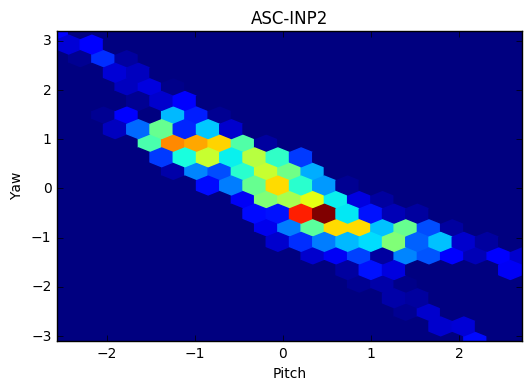

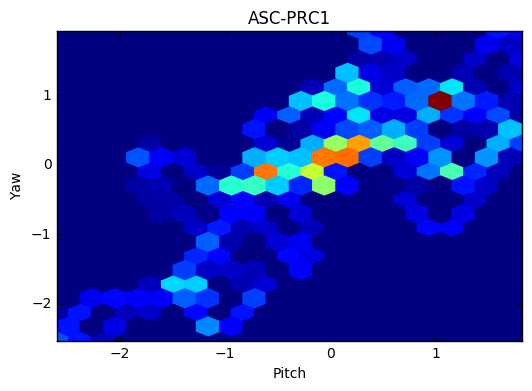

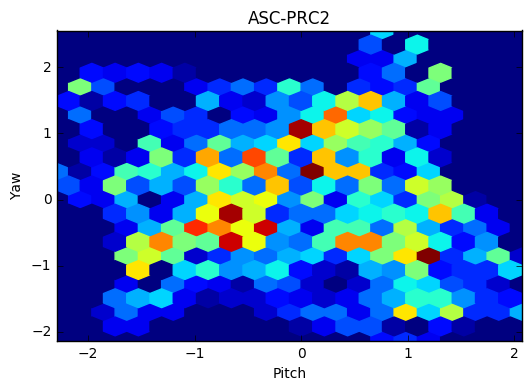

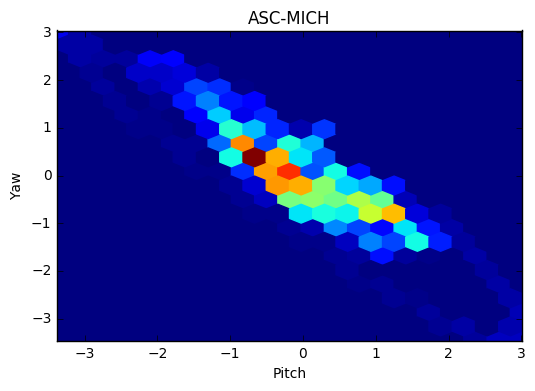

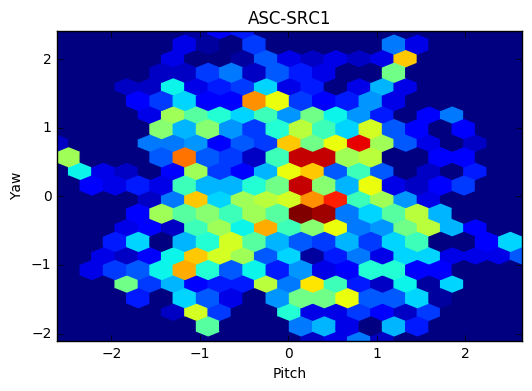

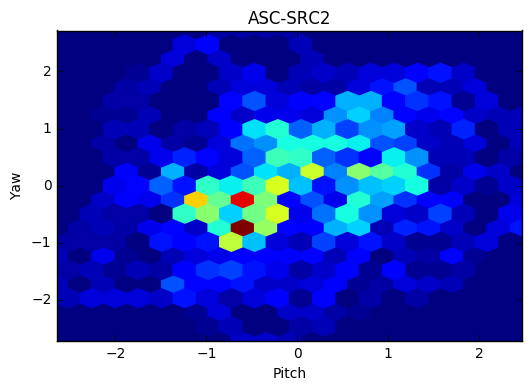

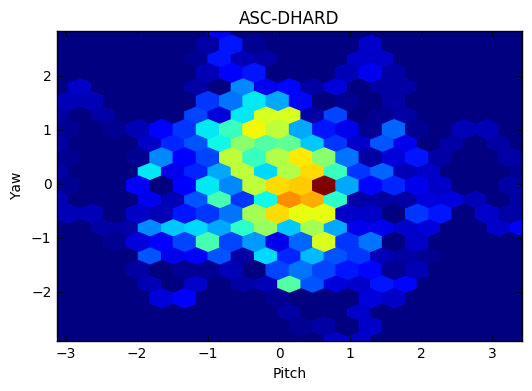

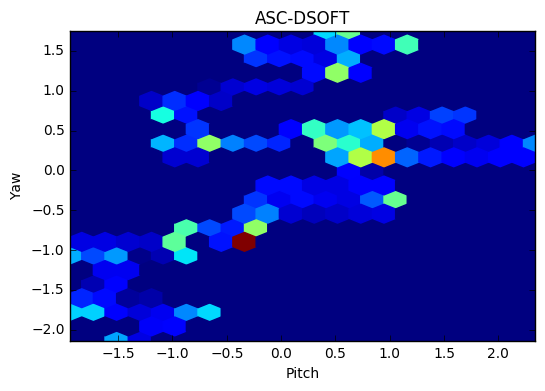

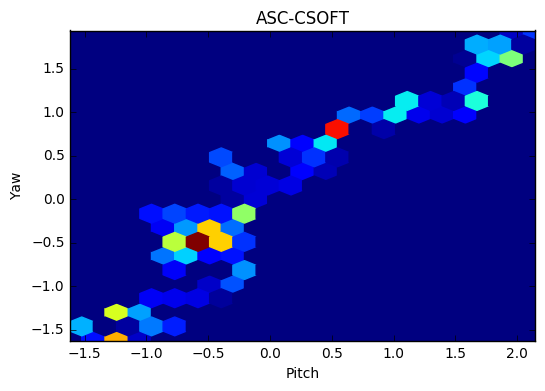

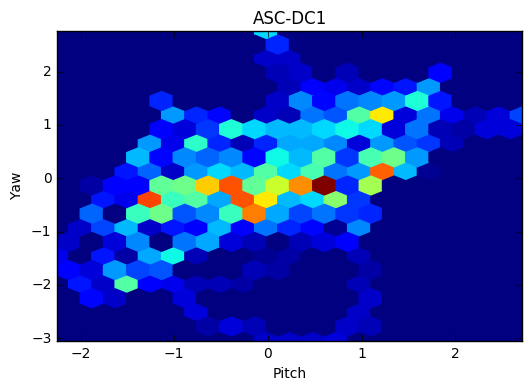

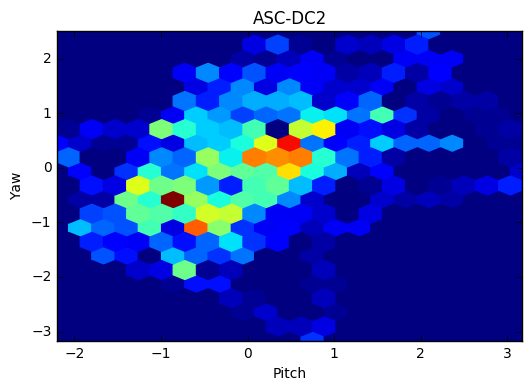

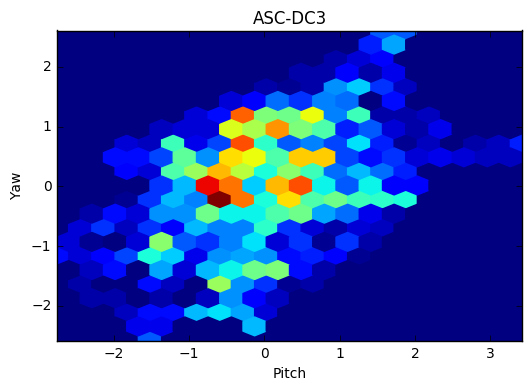

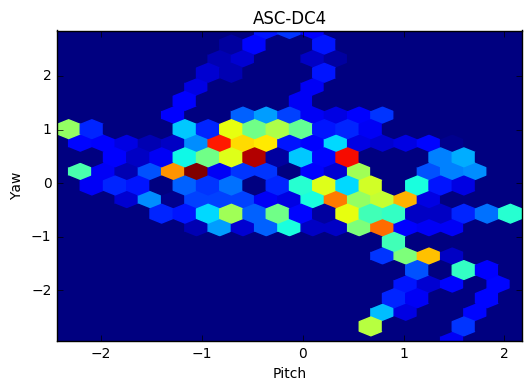

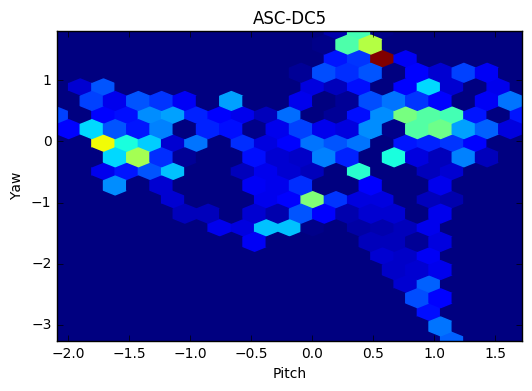

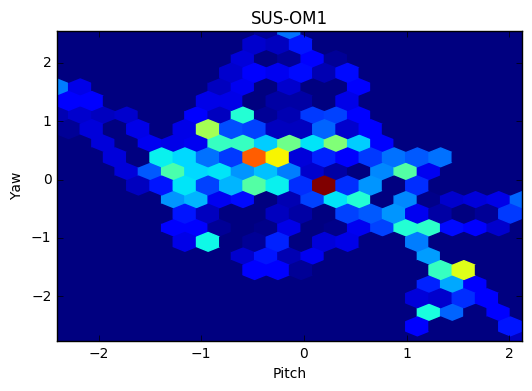

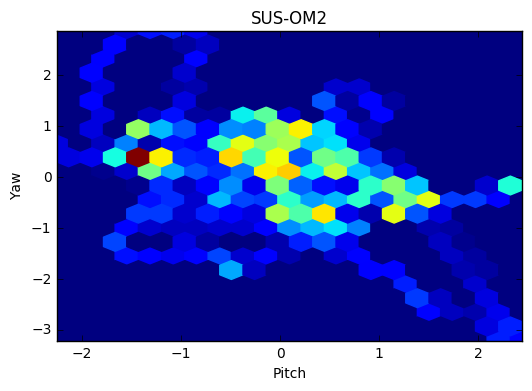

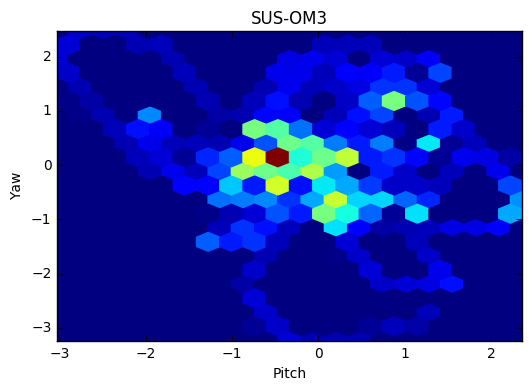

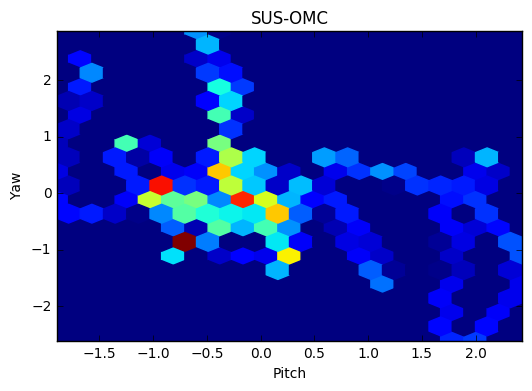

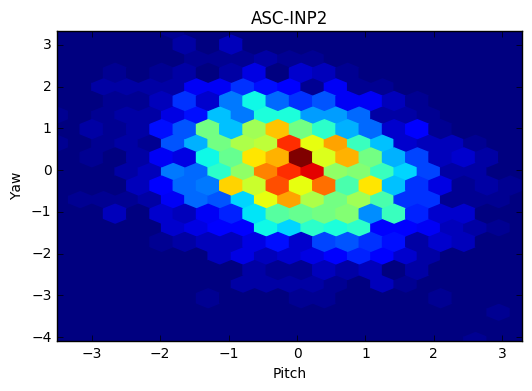

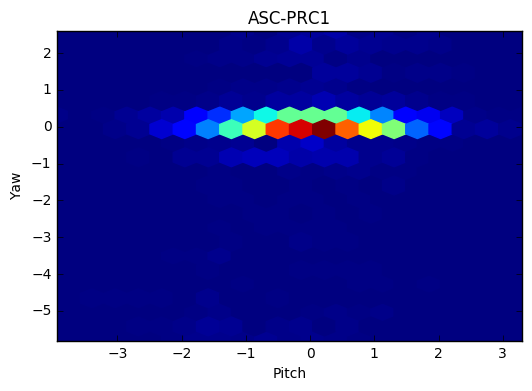

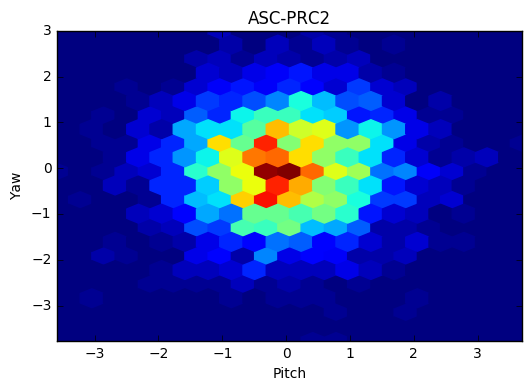

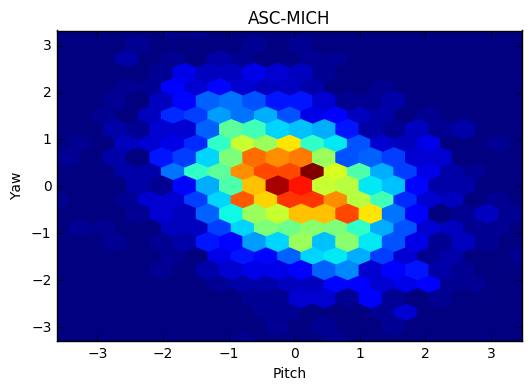

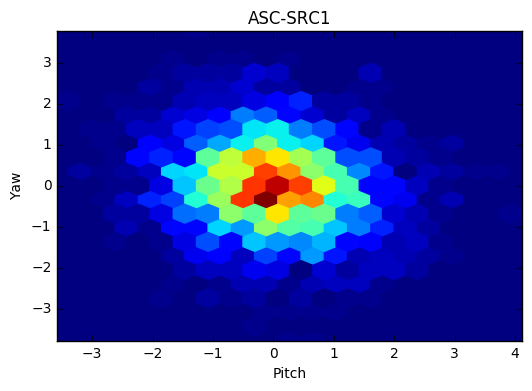

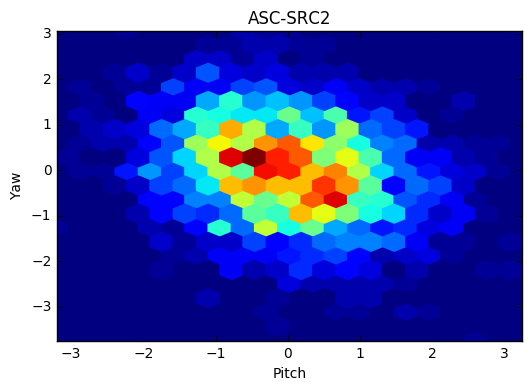

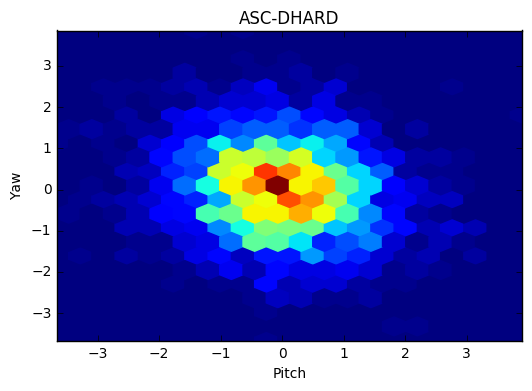

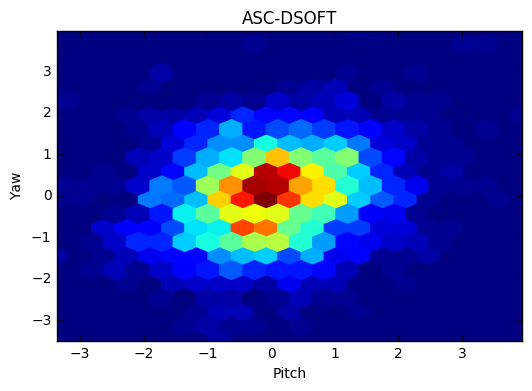

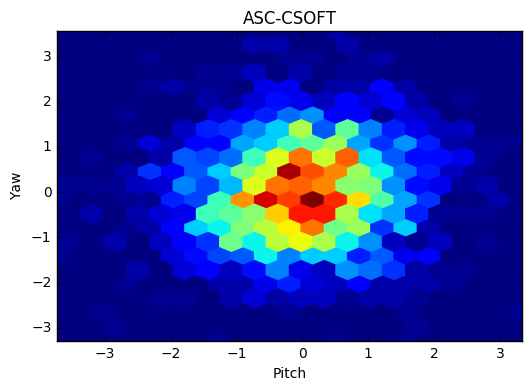

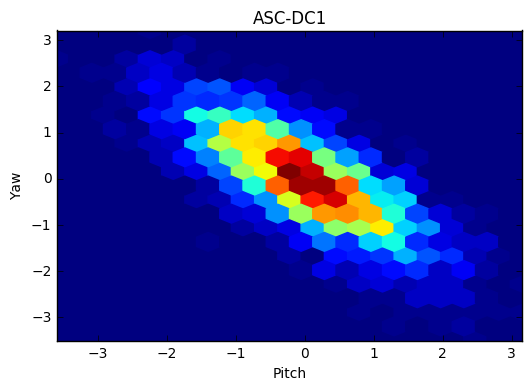

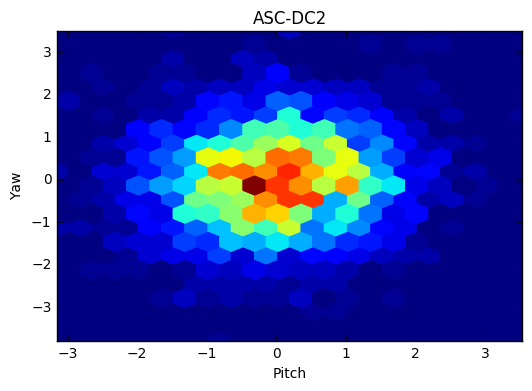

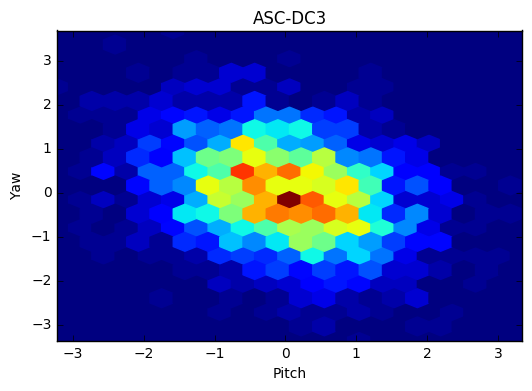

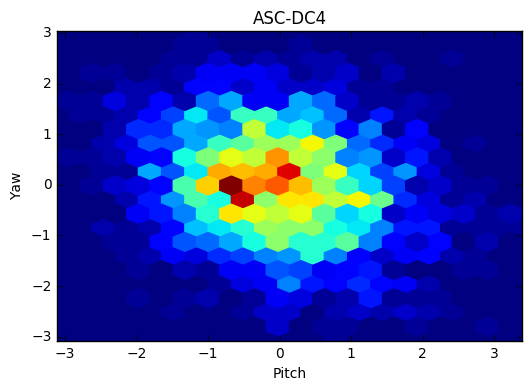

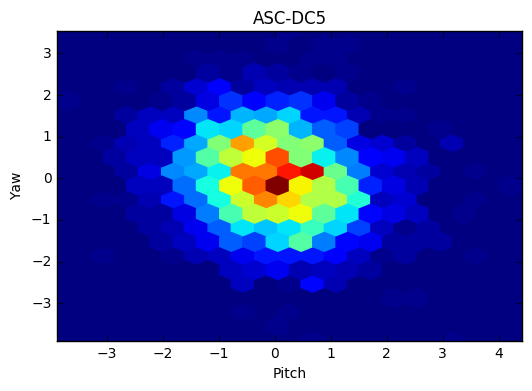

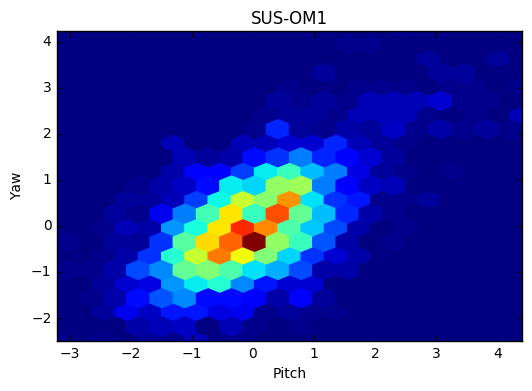

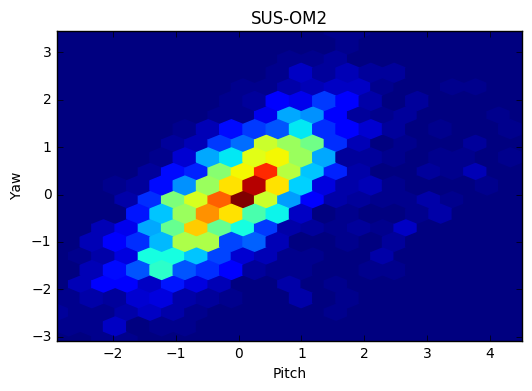

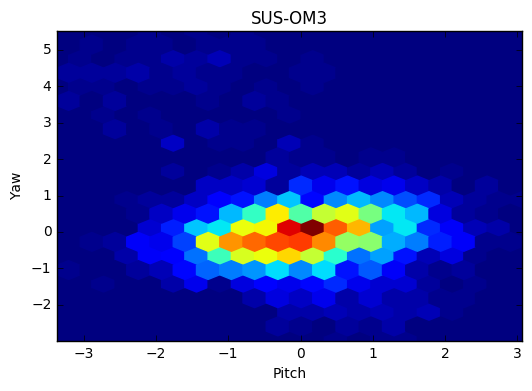

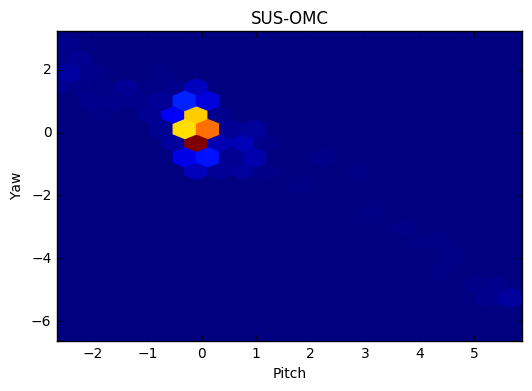

In [87]:
#Producing Density plots of each degree of freedom
for idx in range(0,len(ch_list)-18,1):
    plt.hexbin(A_lp[:,idx],A_lp[:,idx+18],gridsize=20)
    plt.title('%s' % ch_list[idx].split('_')[0])
    plt.xlabel('Pitch')
    plt.ylabel('Yaw')
    plt.show()
    plt.savefig('figs/%s_lp_density.png' % ch_list[idx].split('_')[0])
    
for idx in range(0,len(ch_list)-18,1):
    plt.hexbin(A_hp[:,idx],A_hp[:,idx+18],gridsize=20)
    plt.title('%s' % ch_list[idx].split('_')[0])
    plt.xlabel('Pitch')
    plt.ylabel('Yaw')
    plt.show()
    plt.savefig('figs/%s_hp_density.png' % ch_list[idx].split('_')[0])

In [88]:
#Determining Best Performing Channels and then calculating the PSD

array(ch_list)[pca_lp.components_[0]**2>0.07]

array(['ASC-DSOFT_P_IN1_DQ', 'ASC-CSOFT_P_IN1_DQ',
       'SUS-OM1_M1_DAMP_P_IN1_DQ', 'SUS-OMC_M1_DAMP_P_IN1_DQ',
       'ASC-DSOFT_Y_IN1_DQ', 'ASC-CSOFT_Y_IN1_DQ',
       'ASC-DC4_Y_IN1_DQ'], 
      dtype='|S24')

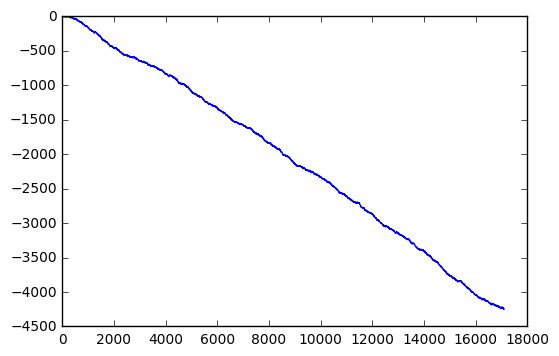

In [134]:
#plt.plot(unwrap(angle(X_r_hp[:,3]+1.j*X_r_hp[:,2])))

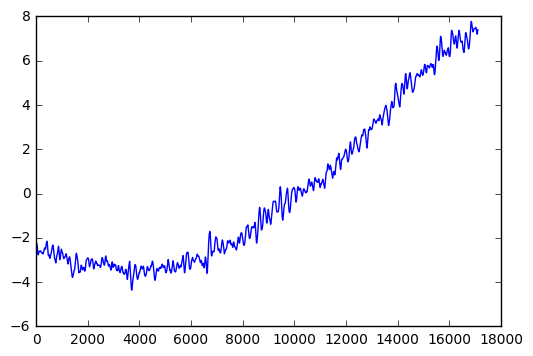

In [136]:
#plt.plot(X_r_lp[:,0])

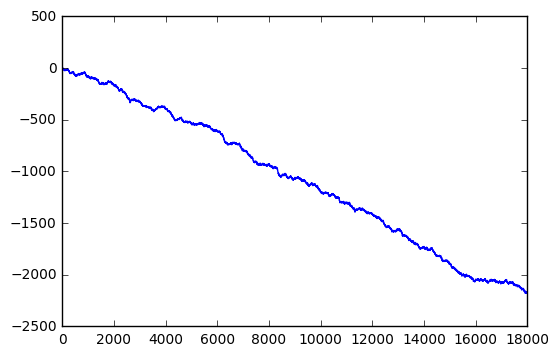

In [18]:
#plt.plot(unwrap(angle(X_r[:,2]+1.j*X_r[:,3])))

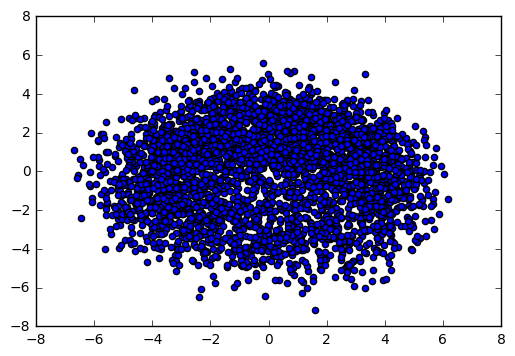

In [20]:
#plt.scatter(X_r[:,0],X_r[:,1])

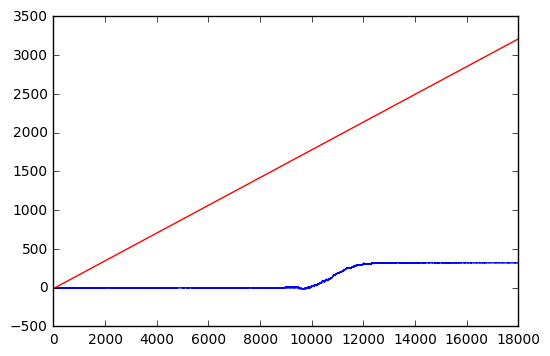

In [19]:
#tarr=arange(len(X_r[:,0]))
#plt.plot(unwrap(arctan2(X_r[:,1],X_r[:,0])))
#plt.plot(tarr,0.179*tarr-11.174,c='r')

In [22]:
#for idx in range(len(ch_list)):
#    print ch_list[idx], pca_lp.components_[0,idx:idx+2], pca_lp.components_[1,idx:idx+2]

ASC-INP2_P_IN1_DQ

NameError: name 'pca_lp' is not defined

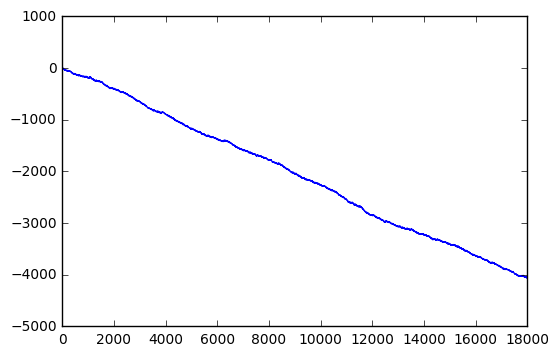

In [22]:
#plt.plot(unwrap(angle(X_r[:,1]+1.j*X_r[:,2])))

In [20]:
#polyfit(tarr,unwrap(angle(X_r[:,2]+1.j*X_r[:,3])),1)

array([ -0.12774962,  76.21326037])

In [74]:
#f01 = fft((X_r[:,2]+1.j*X_r[:,3])-mean(X_r[:,2]+1.j*X_r[:,3]))

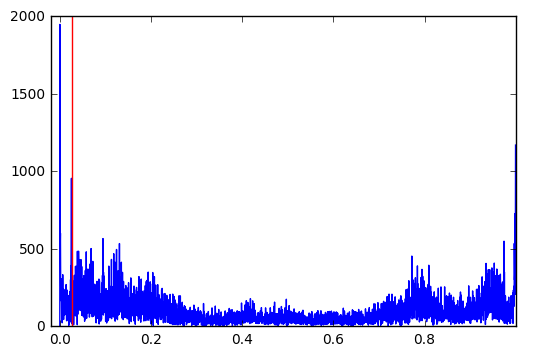

In [76]:
#plt.plot(arange(3600)/3600.,abs(f01))
#plt.gca().set_xlim(-.02,1)
#plt.gca().axvline(0.026,c='r')

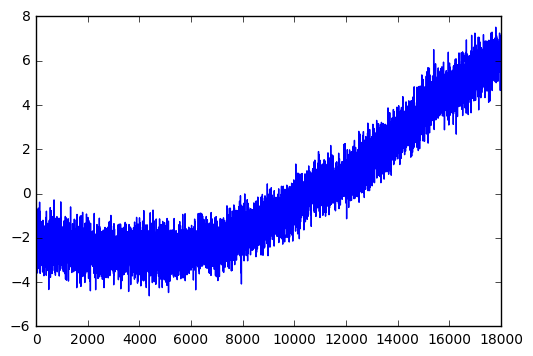

In [28]:
#plt.plot(X_r[:,0])

In [30]:
#pc0=pca.components_[0]
#pc1=pca.components_[1]
#pc2=pca.components_[2]

In [ ]:
if __name__ == "__main__":
    